In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
from keras.optimizers import Adam
# from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
# from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *
import json
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
from keras import backend as K

In [ ]:

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation=None,dilation=(1,1), name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, dilation_rate=dilation, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    # if(activation == None):
    #     return x

    x = Activation(activation, name=name)(x)

    return x

In [ ]:
def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


In [ ]:
def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                        int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out

In [ ]:

def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                          activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                              activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


In [ ]:
# Correct recall for tf
def recall_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(Y_true * Y_pred)
    possible_positives = tf.reduce_sum(Y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [ ]:
# Correct tf precision
def precision_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_true * Y_pred, 0, 1)))
    print(true_positives)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_pred, 0, 1)))
    print(predicted_positives)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [ ]:
# Correct tf dicecoefficient
def dice_coefficient_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    smooth = 1e-5

    intersection = tf.reduce_sum(Y_true * Y_pred)
    union = tf.reduce_sum(Y_true) + tf.reduce_sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [ ]:
def dice_coefficient_for_loss(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)

    Y_pred = K.flatten(y_pred)

    smooth = 1e-5

    intersection = K.sum(Y_true * Y_pred)

    union = K.sum(Y_true) + K.sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [ ]:
# def dice_coef_loss(y_true, y_pred):
#     loss = - dice_coefficient_for_loss(y_true, y_pred)
#     return loss

In [ ]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = 1 - dice_coefficient_for_loss(y_true, y_pred)
    return bce + dice

In [ ]:

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
X_train = np.load('/content/drive/MyDrive/Dataset/X_train.npy')
Y_train = np.load('/content/drive/MyDrive/Dataset/Y_train.npy')


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))


mresblock1 = MultiResBlock(32, inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
mresblock1 = ResPath(32, 4, mresblock1)

mresblock2 = MultiResBlock(32*2, pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
mresblock2 = ResPath(32*2, 3, mresblock2)

mresblock3 = MultiResBlock(32*4, pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
mresblock3 = ResPath(32*4, 2, mresblock3)

mresblock4 = MultiResBlock(32*8, pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
mresblock4 = ResPath(32*8, 1, mresblock4)

mresblock5 = MultiResBlock(32*16, pool4)

up6 = concatenate([Conv2DTranspose(
    32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
mresblock6 = MultiResBlock(32*8, up6)

up7 = concatenate([Conv2DTranspose(
    32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
mresblock7 = MultiResBlock(32*4, up7)

up8 = concatenate([Conv2DTranspose(
    32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
mresblock8 = MultiResBlock(32*2, up8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
    2, 2), padding='same')(mresblock8), mresblock1], axis=3)
mresblock9 = MultiResBlock(32, up9)

conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')

model = Model(inputs=inputs, outputs=conv10)


model.compile(
    optimizer=Adam(learning_rate),
    loss= bce_dice_loss,
    metrics=[
        BinaryAccuracy(name='accuracy'),  # Binary Accuracy
        MeanIoU(num_classes=2, name='iou'),  # Intersection Over Union (IoU)
        recall_tf,  # Sensitivity
        precision_tf,
         tf.keras.metrics.BinaryIoU(
            threshold=0.5,
            name='binaryIoU',
            dtype=None
        ),
        Recall(name='recall_inbuilt'),
        Precision(name='precision_inbuilt'),
        dice_coefficient_tf, # Custom dice coefficient function
        dice_coefficient_for_loss
    ]
)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BCE+DiceLoss/model_for_heart128.h5', verbose=1, save_best_only=True)


callbacks = [
               tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir = '/content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BCE+DiceLoss'),
              checkpointer
]

# Saving the accuracy as the model gets trained

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=150, callbacks=callbacks)
model.save('/content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BCE+DiceLoss/multiresunet_model128.h5')


# Saving the data
with open('/content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BCE+DiceLoss/training_history128.json', 'w') as file:
     json.dump(results.history, file)
#     # return model

Epoch 1/150
Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)
Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)
129/129 [==============================] - ETA: 0s - loss: 1.4593 - accuracy: 0.9176 - iou: 0.4818 - recall_tf: 0.9636 - precision_tf: 0.4794 - binaryIoU: 0.6062 - recall_inbuilt: 0.9630 - precision_inbuilt: 0.3012 - dice_coefficient_tf: 0.6053 - dice_coefficient_for_loss: 0.1333Tensor("Sum_6:0", shape=(), dtype=float32)
Tensor("Sum_7:0", shape=(), dtype=float32)

Epoch 1: val_loss improved from inf to 1.48613, saving model to /content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BCE+DiceLoss/model_for_heart128.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 92s 304ms/step - loss: 1.4593 - accuracy: 0.9176 - iou: 0.4818 - recall_tf: 0.9636 - precision_tf: 0.4794 - binaryIoU: 0.6062 - recall_inbuilt: 0.9630 - precision_inbuilt: 0.3012 - dice_coefficient_tf: 0.6053 - dice_coefficient_for_loss: 0.1333 - val_loss: 1.4861 - val_accuracy: 0.9584 - val_iou: 0.4771 - val_recall_tf: 0.0555 - val_precision_tf: 0.2944 - val_binaryIoU: 0.5392 - val_recall_inbuilt: 0.1241 - val_precision_inbuilt: 0.7976 - val_dice_coefficient_tf: 0.0883 - val_dice_coefficient_for_loss: 0.0768
Epoch 2/150
129/129 [==============================] - ETA: 0s - loss: 1.3689 - accuracy: 0.9847 - iou: 0.4818 - recall_tf: 0.9852 - precision_tf: 0.6985 - binaryIoU: 0.8423 - recall_inbuilt: 0.9832 - precision_inbuilt: 0.7090 - dice_coefficient_tf: 0.8071 - dice_coefficient_for_loss: 0.1481
Epoch 2: val_loss improved from 1.48613 to 1.34204, saving model to /content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BCE

In [ ]:
X_test = np.load('/content/drive/MyDrive/Dataset/X_test.npy')
Y_test = np.load('/content/drive/MyDrive/Dataset/Y_test.npy')

In [ ]:
results = model.evaluate(X_test, Y_test)

8/8 [==============================] - 6s 480ms/step - loss: 0.3823 - accuracy: 0.9953 - iou: 0.4825 - recall_tf: 0.8921 - precision_tf: 0.9691 - binaryIoU: 0.9325 - recall_inbuilt: 0.8961 - precision_inbuilt: 0.9674 - dice_coefficient_tf: 0.9282 - dice_coefficient_for_loss: 0.6521


In [ ]:
labels = ['loss', 'accuracy', 'iou', 'recall', 'precision', 'binaryIoU', 'recall_inbuilt', 'precision_inbuilt', 'dice_coefficient_tf', 'dice_coeff_for_loss']
results_dict = dict(zip(labels, results))

with open('/content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BCE+DiceLoss/Graph/testing_results_final.json', 'w') as json_file:
    json.dump(results_dict, json_file)

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype(np.uint8)

8/8 [==============================] - 2s 111ms/step


In [ ]:
# [[TN, FP],
 # [FN, TP]]
from sklearn.metrics import confusion_matrix, classification_report
conf_mat = confusion_matrix(Y_test.flatten(), y_pred.flatten())
print(conf_mat)

[[3995505    4393]
 [  15085  130169]]


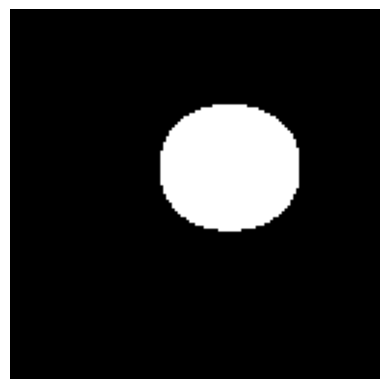

In [ ]:
plt.imshow(Y_test[245], cmap='gray')  # Use 'gray' colormap for grayscale images
# plt.imshow(Y_test[24], cmap='gray')  # Use 'gray' colormap for grayscale images
# plt.title('Image X_test[24]-->61.png')
plt.axis('off')  # Optional to hide axis labels
plt.show()

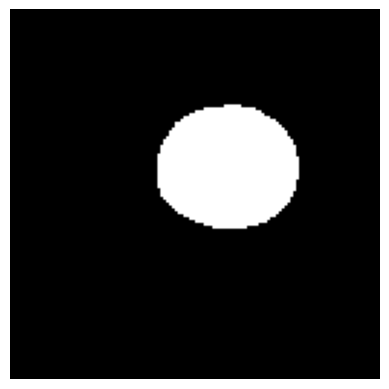

In [ ]:
plt.imshow(y_pred[245], cmap='gray')  # Use 'gray' colormap for grayscale images
# plt.imshow(Y_test[24], cmap='gray')  # Use 'gray' colormap for grayscale images
# plt.title('Image X_test[24]-->61.png')
plt.axis('off')  # Optional to hide axis labels
plt.show()